In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

In [2]:
input_dir = 'output-files-bootstrap-test6b-2d-2a'


with open( '%s/train-and-true-samples.npy' % input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    
print('\n\n')
print(' shape of train_pts:  %s' % str(train_pts.shape))
print(' shape of true_pts:   %s' % str(true_pts.shape))
print('\n\n')






 shape of train_pts:  (400000, 2)
 shape of true_pts:   (40000, 2)





In [3]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [4]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)



 Number of feature dimensions: 2




In [5]:
with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)

<function matplotlib.pyplot.show(close=None, block=None)>

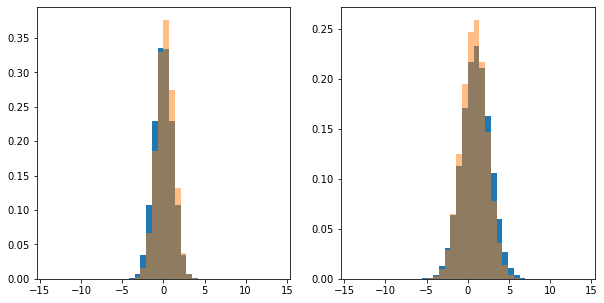

In [6]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))



hmin=-5
hmax=5


hmin=-14
hmax=14

hbins=40


for i in range(ndim) :
        ax[i].hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

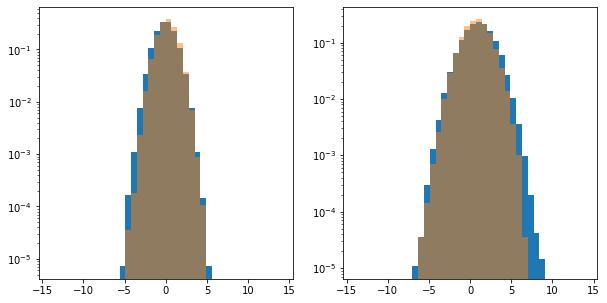

In [7]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins=40


for i in range(ndim) :
        ax[i].hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
        ax[i].set_yscale('log')
    
plt.show

In [8]:
with open( "%s/omnifold-output-weights.npy" % input_dir,'rb') as f :
    main_sample_omnifold_weights = np.load(f)


<function matplotlib.pyplot.show(close=None, block=None)>

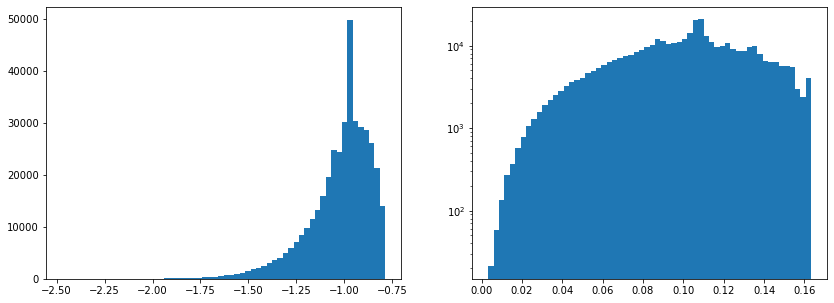

In [9]:
fig,ax = plt.subplots( 1, 2, figsize=(2*7,5))

hbins = 60
ax[0].hist( np.log10(main_sample_omnifold_weights), bins=hbins)
ax[1].hist( main_sample_omnifold_weights, bins=hbins)
ax[1].set_yscale('log')
plt.show

In [10]:
true_rho

array([[-0.6]])

In [11]:
true_mu.shape

(2,)

In [12]:
true_cov = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        k = ndim - j - 1
        if i == j :
            true_cov[i][j] = true_sig[i]*true_sig[i]
        elif j > i :
            print(" %d, %d, %d" % (i,j,k))
            true_cov[i][j] = true_rho[i][k] * true_sig[i] * true_sig[j]

 0, 1, 0


In [13]:
true_cov

array([[ 0.81 , -0.702],
       [ 0.   ,  1.69 ]])

In [14]:
have_fits = False

if exists( "%s/fit-results.npy" % input_dir ) :
    have_fits = True
    print("\n\n Have fit results file.\n\n")

In [15]:
if have_fits :
    
    with open( '%s/fit-results.npy' % input_dir, 'rb' ) as f :
        fit_results_mean_val = np.load(f, allow_pickle=True )
        fit_results_mean_err = np.load(f, allow_pickle=True )
        fit_results_cov_val = np.load(f, allow_pickle=True )
        fit_results_cov_err = np.load(f, allow_pickle=True )        
        

    ave_fit_err_mean = np.zeros( ndim )

    for fi in range(ndim) :
    
        ave_fit_err_mean[fi] = np.mean( fit_results_mean_err[fi,:])
    

In [16]:
def calc_mean( weights, fi ) :
    
    mean = ( np.sum( weights * train_pts[:,fi]) ) / ( np.sum( weights ) )
    
    return mean

In [17]:
def calc_rms( weights, fi ) :
    
    x = calc_mean( weights, fi )
    xx = ( np.sum( weights * train_pts[:,fi] * train_pts[:,fi] ) ) / ( np.sum( weights ) )
    
    #print(" x = %f,  xx = %f" % (x, xx))
    
    return np.sqrt(xx - x*x)


In [18]:
def calc_cov( weights, fi1, fi2 ) :
    
    x1 = calc_mean( weights, fi1 )
    x2 = calc_mean( weights, fi2 )
    x1x2 = ( np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] ) ) / ( np.sum( weights ) )
    
    return np.sqrt( x1x2 - x1*x2 )
    

In [19]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [20]:
n_samples = 0

for fi in range(1000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 500 bootstrap samples.




In [21]:
%%time

all_mean = np.zeros( shape=(ndim,n_samples) )
all_rms = np.zeros( shape=(ndim,n_samples) )
all_cov = np.zeros( shape=(ndim,ndim,n_samples) )
all_rho = np.zeros( shape=(ndim,ndim,n_samples) )

all_weight_min = np.zeros( n_samples )
all_weight_max = np.zeros( n_samples )


si = 0

for fi in range(500) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        
        print('\n----- %s exists' % fname )
        
        with open(fname,'rb') as f :
            
            final_push_weights_scaled = np.load(f)
            print( len(final_push_weights_scaled))
            print( final_push_weights_scaled )
            print( true_pts[:,0])
            
            all_weight_min[si] = np.min( final_push_weights_scaled )
            all_weight_max[si] = np.max( final_push_weights_scaled )
            
            for fi1 in range(ndim) :
                for fi2 in range(fi1,ndim) :
                    mean_cov = calc_mean_cov( final_push_weights_scaled, fi1, fi2 )
                    all_cov[fi1,fi2,si] = mean_cov["cov_x1x2"]
                    all_cov[fi2,fi1,si] = mean_cov["cov_x1x2"]
                    if ( fi1 == fi2 ) :
                        print( "  %d %d  :  mean = %8.4f, RMS = %8.4f, cov = %8.4f" % 
                              (fi1, fi2, mean_cov["mean_x1"], mean_cov["rms1"], mean_cov["cov_x1x2"]))
                        all_mean[fi1,si] = mean_cov["mean_x1"]
                        all_rms[fi1,si] = mean_cov["rms1"]
                    else :
                        print( "  %d %d  :  rho = %8.4f,  cov = %8.4f" %
                              (fi1, fi2, mean_cov["rho12"], mean_cov["cov_x1x2"]) )
                        all_rho[fi1,fi2,si] = mean_cov["rho12"]
                        all_rho[fi2,fi1,si] = mean_cov["rho12"]
                        
        si = si + 1
        
            


----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-000.npy exists
400000
[0.10844268 0.03515332 0.01888046 ... 0.11531934 0.13910435 0.0708275 ]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2071, RMS =   0.9071, cov =   0.8229
  0 1  :  rho =  -0.5991,  cov =  -0.7082
  1 1  :  mean =   0.7950, RMS =   1.3030, cov =   1.6977

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-001.npy exists
400000
[0.09540007 0.03395961 0.01744306 ... 0.07395086 0.1594827  0.0752108 ]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2080, RMS =   0.8954, cov =   0.8017
  0 1  :  rho =  -0.5898,  cov =  -0.6799
  1 1  :  mean =   0.8052, RMS =   1.2875, cov =   1.6577

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-002.npy exists
400000
[0.10899686 0.03854791 0.02322087 ... 0.06893313 0.1346456  0.07240107]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603

  1 1  :  mean =   0.7973, RMS =   1.2880, cov =   1.6588

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-028.npy exists
400000
[0.0482625  0.03495727 0.02247255 ... 0.05133081 0.16090806 0.08049575]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2055, RMS =   0.9095, cov =   0.8272
  0 1  :  rho =  -0.5940,  cov =  -0.7045
  1 1  :  mean =   0.7888, RMS =   1.3041, cov =   1.7006

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-029.npy exists
400000
[0.05724032 0.03546262 0.01593688 ... 0.01223072 0.18378642 0.07750013]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2071, RMS =   0.8960, cov =   0.8028
  0 1  :  rho =  -0.6033,  cov =  -0.7012
  1 1  :  mean =   0.7964, RMS =   1.2972, cov =   1.6828

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-030.npy exists
400000
[0.07386992 0.03016428 0.01348851 ... 0.06054819 0.18124618 0.07026336]
[ 1

  0 1  :  rho =  -0.5946,  cov =  -0.6985
  1 1  :  mean =   0.8007, RMS =   1.3059, cov =   1.7053

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-062.npy exists
400000
[0.08147231 0.03658105 0.01591041 ... 0.03471404 0.14473637 0.06995964]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2115, RMS =   0.8998, cov =   0.8097
  0 1  :  rho =  -0.5847,  cov =  -0.6766
  1 1  :  mean =   0.7862, RMS =   1.2860, cov =   1.6537

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-063.npy exists
400000
[0.08877676 0.03944048 0.0319969  ... 0.03821572 0.10110685 0.06606609]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2023, RMS =   0.9044, cov =   0.8180
  0 1  :  rho =  -0.5908,  cov =  -0.6953
  1 1  :  mean =   0.7816, RMS =   1.3013, cov =   1.6934

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-064.npy exists
400000
[0.07113511 0.03678635 0.02103713

  0 1  :  rho =  -0.5886,  cov =  -0.6883
  1 1  :  mean =   0.7790, RMS =   1.3020, cov =   1.6952

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-096.npy exists
400000
[0.09956758 0.03560505 0.02323851 ... 0.02920339 0.15809874 0.07435548]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2081, RMS =   0.9016, cov =   0.8128
  0 1  :  rho =  -0.6015,  cov =  -0.7049
  1 1  :  mean =   0.8022, RMS =   1.2998, cov =   1.6894

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-097.npy exists
400000
[0.08315913 0.0308943  0.01670471 ... 0.02185141 0.15375983 0.07952486]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2143, RMS =   0.9074, cov =   0.8234
  0 1  :  rho =  -0.5949,  cov =  -0.7038
  1 1  :  mean =   0.7779, RMS =   1.3038, cov =   1.6998

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-098.npy exists
400000
[0.08186896 0.0322413  0.02468849

  0 1  :  rho =  -0.6002,  cov =  -0.7006
  1 1  :  mean =   0.7974, RMS =   1.3045, cov =   1.7016

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-130.npy exists
400000
[0.07597994 0.03071788 0.01709322 ... 0.01550763 0.1294855  0.07120788]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2064, RMS =   0.9012, cov =   0.8122
  0 1  :  rho =  -0.5878,  cov =  -0.6843
  1 1  :  mean =   0.7942, RMS =   1.2920, cov =   1.6691

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-131.npy exists
400000
[0.08763629 0.04045585 0.03318972 ... 0.0214412  0.12679223 0.08379789]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.1942, RMS =   0.9097, cov =   0.8276
  0 1  :  rho =  -0.5867,  cov =  -0.6975
  1 1  :  mean =   0.7956, RMS =   1.3068, cov =   1.7078

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-132.npy exists
400000
[0.06983196 0.03136653 0.02338218

  0 1  :  rho =  -0.6002,  cov =  -0.6848
  1 1  :  mean =   0.7879, RMS =   1.2833, cov =   1.6468

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-164.npy exists
400000
[0.07766539 0.03641416 0.01384658 ... 0.01490042 0.14445655 0.07610449]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.1986, RMS =   0.9010, cov =   0.8118
  0 1  :  rho =  -0.5965,  cov =  -0.6926
  1 1  :  mean =   0.8034, RMS =   1.2887, cov =   1.6608

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-165.npy exists
400000
[0.08284499 0.03610711 0.0204822  ... 0.01443628 0.13720599 0.07500471]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2038, RMS =   0.9063, cov =   0.8213
  0 1  :  rho =  -0.6003,  cov =  -0.7088
  1 1  :  mean =   0.7972, RMS =   1.3030, cov =   1.6978

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-166.npy exists
400000
[0.09191382 0.03359451 0.01184037

  0 1  :  rho =  -0.5859,  cov =  -0.6838
  1 1  :  mean =   0.7945, RMS =   1.3007, cov =   1.6918

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-198.npy exists
400000
[0.08708022 0.03717942 0.01990221 ... 0.09701775 0.12656988 0.07660571]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2057, RMS =   0.9028, cov =   0.8150
  0 1  :  rho =  -0.5894,  cov =  -0.6890
  1 1  :  mean =   0.7926, RMS =   1.2950, cov =   1.6770

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-199.npy exists
400000
[0.09130942 0.03476441 0.01448131 ... 0.06952994 0.11311928 0.08433052]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2022, RMS =   0.9011, cov =   0.8120
  0 1  :  rho =  -0.5955,  cov =  -0.6980
  1 1  :  mean =   0.7997, RMS =   1.3007, cov =   1.6918

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-200.npy exists
400000
[0.07794245 0.04024815 0.02387868

  1 1  :  mean =   0.7944, RMS =   1.3017, cov =   1.6945

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-232.npy exists
400000
[0.10628939 0.03543335 0.01360687 ... 0.10486447 0.13488022 0.0719697 ]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.1994, RMS =   0.8975, cov =   0.8055
  0 1  :  rho =  -0.5891,  cov =  -0.6814
  1 1  :  mean =   0.7913, RMS =   1.2886, cov =   1.6605

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-233.npy exists
400000
[0.08199197 0.04003072 0.01344207 ... 0.10166415 0.13854602 0.07516137]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2067, RMS =   0.8981, cov =   0.8065
  0 1  :  rho =  -0.5996,  cov =  -0.6988
  1 1  :  mean =   0.7842, RMS =   1.2978, cov =   1.6844

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-234.npy exists
400000
[0.09135662 0.03703264 0.01829331 ... 0.0918324  0.1635926  0.07438433]
[ 1


----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-266.npy exists
400000
[0.09256129 0.03892182 0.0198534  ... 0.1145243  0.13957082 0.0725062 ]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.1991, RMS =   0.9001, cov =   0.8102
  0 1  :  rho =  -0.5905,  cov =  -0.6900
  1 1  :  mean =   0.8039, RMS =   1.2984, cov =   1.6858

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-267.npy exists
400000
[0.0920626  0.03727182 0.0141541  ... 0.12060197 0.13382226 0.06989253]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.1982, RMS =   0.8957, cov =   0.8022
  0 1  :  rho =  -0.5896,  cov =  -0.6774
  1 1  :  mean =   0.7928, RMS =   1.2827, cov =   1.6452

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-268.npy exists
400000
[0.08986341 0.03491037 0.01859448 ... 0.11234225 0.13229458 0.06910825]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603

  1 1  :  mean =   0.7991, RMS =   1.2858, cov =   1.6533

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-300.npy exists
400000
[0.08446336 0.03265249 0.01618267 ... 0.07909509 0.12519052 0.06995101]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2146, RMS =   0.8930, cov =   0.7974
  0 1  :  rho =  -0.5948,  cov =  -0.6873
  1 1  :  mean =   0.7794, RMS =   1.2940, cov =   1.6743

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-301.npy exists
400000
[0.08026411 0.03625125 0.01431682 ... 0.10793459 0.13343082 0.0694923 ]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2153, RMS =   0.8967, cov =   0.8041
  0 1  :  rho =  -0.5929,  cov =  -0.6844
  1 1  :  mean =   0.7895, RMS =   1.2872, cov =   1.6568

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-302.npy exists
400000
[0.07779424 0.03873385 0.01910997 ... 0.0763927  0.12779315 0.07013924]
[ 1

  0 1  :  rho =  -0.5910,  cov =  -0.6873
  1 1  :  mean =   0.7930, RMS =   1.2863, cov =   1.6546

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-334.npy exists
400000
[0.09981612 0.03294622 0.01722388 ... 0.08817173 0.14624214 0.06876279]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2038, RMS =   0.8954, cov =   0.8018
  0 1  :  rho =  -0.5935,  cov =  -0.6861
  1 1  :  mean =   0.7893, RMS =   1.2912, cov =   1.6671

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-335.npy exists
400000
[0.09192891 0.03647037 0.01838258 ... 0.09168912 0.14300368 0.07726632]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2052, RMS =   0.9012, cov =   0.8122
  0 1  :  rho =  -0.6071,  cov =  -0.7114
  1 1  :  mean =   0.7892, RMS =   1.3003, cov =   1.6907

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-336.npy exists
400000
[0.09448778 0.0345286  0.0205382 

  1 1  :  mean =   0.7934, RMS =   1.2996, cov =   1.6889

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-368.npy exists
400000
[0.09510066 0.04705084 0.02005801 ... 0.10430081 0.12484908 0.0716056 ]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2008, RMS =   0.9101, cov =   0.8284
  0 1  :  rho =  -0.6027,  cov =  -0.7155
  1 1  :  mean =   0.7944, RMS =   1.3044, cov =   1.7014

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-369.npy exists
400000
[0.08118559 0.03109975 0.01237623 ... 0.07539491 0.11472484 0.06427537]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2018, RMS =   0.8989, cov =   0.8080
  0 1  :  rho =  -0.6081,  cov =  -0.7067
  1 1  :  mean =   0.7908, RMS =   1.2928, cov =   1.6714

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-370.npy exists
400000
[0.10134891 0.04077491 0.01446149 ... 0.06182707 0.11744818 0.07774678]
[ 1

  0 1  :  rho =  -0.5915,  cov =  -0.6783
  1 1  :  mean =   0.7994, RMS =   1.2820, cov =   1.6436

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-402.npy exists
400000
[0.07343364 0.03955407 0.0179384  ... 0.04131571 0.14979212 0.06034913]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2026, RMS =   0.8932, cov =   0.7978
  0 1  :  rho =  -0.5982,  cov =  -0.6966
  1 1  :  mean =   0.8007, RMS =   1.3037, cov =   1.6996

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-403.npy exists
400000
[0.11342881 0.03938411 0.0193439  ... 0.0753902  0.14266347 0.06214915]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.1964, RMS =   0.8955, cov =   0.8020
  0 1  :  rho =  -0.5933,  cov =  -0.6910
  1 1  :  mean =   0.8035, RMS =   1.3006, cov =   1.6917

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-404.npy exists
400000
[0.09019575 0.02890078 0.00970904

  0 0  :  mean =   0.1958, RMS =   0.8951, cov =   0.8012
  0 1  :  rho =  -0.5942,  cov =  -0.6867
  1 1  :  mean =   0.8134, RMS =   1.2912, cov =   1.6672

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-436.npy exists
400000
[0.11784739 0.04411493 0.02705429 ... 0.06681006 0.14682371 0.07548833]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2043, RMS =   0.9048, cov =   0.8187
  0 1  :  rho =  -0.5996,  cov =  -0.7027
  1 1  :  mean =   0.8017, RMS =   1.2952, cov =   1.6775

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-437.npy exists
400000
[0.09403697 0.03853826 0.02126732 ... 0.07724242 0.14090354 0.06726972]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2108, RMS =   0.9035, cov =   0.8162
  0 1  :  rho =  -0.5943,  cov =  -0.6970
  1 1  :  mean =   0.7992, RMS =   1.2980, cov =   1.6848

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weigh

  1 1  :  mean =   0.7912, RMS =   1.2939, cov =   1.6741

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-469.npy exists
400000
[0.07587558 0.03195333 0.01356648 ... 0.00589966 0.10328018 0.06987236]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2053, RMS =   0.8981, cov =   0.8065
  0 1  :  rho =  -0.5892,  cov =  -0.6830
  1 1  :  mean =   0.7888, RMS =   1.2908, cov =   1.6661

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-470.npy exists
400000
[0.07364484 0.03417914 0.03909049 ... 0.00441361 0.12504284 0.07691299]
[ 1.99413041  0.36647098  1.70599869 ... -0.68985378 -0.14603325
  1.32381317]
  0 0  :  mean =   0.2111, RMS =   0.9068, cov =   0.8224
  0 1  :  rho =  -0.5951,  cov =  -0.7053
  1 1  :  mean =   0.7969, RMS =   1.3071, cov =   1.7085

----- output-files-bootstrap-test6b-2d-2a/bootstrap-weights-471.npy exists
400000
[0.1494005  0.03634786 0.02685557 ... 0.0101661  0.11491789 0.07010855]
[ 1

<function matplotlib.pyplot.show(close=None, block=None)>

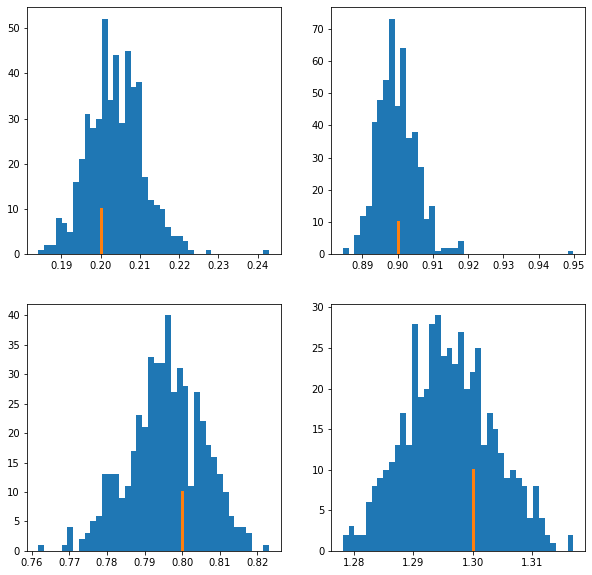

In [22]:
fig,ax = plt.subplots( ndim, 2, figsize=(2*5,ndim*5))

ymax = 10

for i in range(ndim) :
    
    ax[i][0].hist( all_mean[i], bins=40)
    ax[i][1].hist( all_rms[i], bins=40)
    
    ax[i][0].plot( (true_mu[i], true_mu[i]), (0,ymax), linewidth=3 )
    ax[i][1].plot( (true_sig[i], true_sig[i]), (0,ymax), linewidth=3 )

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

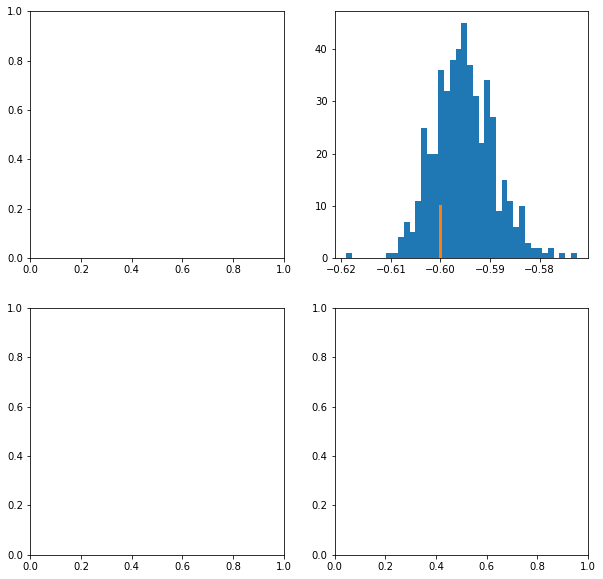

In [23]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5,ndim*5))

ymax = 10

for i in range(0,ndim-1) :
    
    for j in range(i+1,ndim) :
        
        k = ndim - j - 1
        
        ax[i][j].hist( all_rho[i,j], bins=40)
        
        ax[i][j].plot( (true_rho[i][k], true_rho[i][k]), (0, ymax), linewidth=3 )
    


plt.show

In [24]:
print('\n')

ave_mean = np.zeros( ndim )
rms_mean = np.zeros( ndim )

ave_cov = np.zeros( shape=(ndim,ndim) )
rms_cov = np.zeros( shape=(ndim,ndim) )


for fi in range(ndim) :
    
    ave_mean[fi] = np.mean( all_mean[fi] )
    ave_mean2 = np.mean( all_mean[fi]*all_mean[fi])
    rms_mean[fi] = np.sqrt( ave_mean2 - ave_mean[fi]*ave_mean[fi] )
    print("  feature %d  :  mean   ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_mean[fi], true_mu[fi], rms_mean[fi] ))
    
print('\n')

for fi in range(ndim) :
    
    ave_rms = np.mean( all_rms[fi] )
    ave_rms2 = np.mean( all_rms[fi]*all_rms[fi])
    rms_rms = np.sqrt( ave_rms2 - ave_rms*ave_rms )
    print("  feature %d  :  RMS    ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_rms, true_sig[fi], rms_rms ))
    
print('\n')

for fi1 in range(0,ndim-1) :
    for fi2 in range(fi1+1, ndim) :
        k = ndim - fi2 - 1
        ave_rho = np.mean( all_rho[fi1,fi2])
        ave_rho2 = np.mean( all_rho[fi1,fi2]*all_rho[fi1,fi2] )
        rms_rho = np.sqrt( ave_rho2 - ave_rho*ave_rho )
        print("  feature %d, %d  :  rho    ave %8.4f  (true %8.4f), rms %8.4f" % ( fi1, fi2, ave_rho, true_rho[fi1][k], rms_rho ))
        
print("\n")

for fi1 in range(0,ndim) :
    for fi2 in range(fi1,ndim) :
        ave_cov[fi1,fi2] = np.mean( all_cov[fi1][fi2] )
        ave_cov2 = np.mean( all_cov[fi1][fi2]*all_cov[fi1][fi2] )
        rms_cov[fi1,fi2] = np.sqrt( ave_cov2 - ave_cov[fi1,fi2]*ave_cov[fi1,fi2] )
        print("  feature %d, %d  :  cov    ave %8.4f  (true %8.4f), rms %8.4f" %
              (fi1, fi2, ave_cov[fi1,fi2], true_cov[fi1,fi2], rms_cov[fi1,fi2] ) )

print("\n")



  feature 0  :  mean   ave   0.2038  (true   0.2000), rms   0.0071
  feature 1  :  mean   ave   0.7957  (true   0.8000), rms   0.0098


  feature 0  :  RMS    ave   0.8998  (true   0.9000), rms   0.0058
  feature 1  :  RMS    ave   1.2961  (true   1.3000), rms   0.0073


  feature 0, 1  :  rho    ave  -0.5953  (true  -0.6000), rms   0.0061


  feature 0, 0  :  cov    ave   0.8096  (true   0.8100), rms   0.0105
  feature 0, 1  :  cov    ave  -0.6942  (true  -0.7020), rms   0.0106
  feature 1, 1  :  cov    ave   1.6799  (true   1.6900), rms   0.0189




## Save the simple direct calculation results for setting fit parameter ranges from RMS.

In [25]:
with open( '%s/simple-calc-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, ave_mean )
    np.save( f, rms_mean )
    np.save( f, ave_cov )
    np.save( f, rms_cov )

In [26]:
if have_fits :
    
    for si in range( n_samples ) :
        
        for fi in range( 1,2 ) :
            print("  sample %3d :  mean%d   calc  %8.4f  fit %8.4f" % 
                  (si, fi, all_mean[fi,si], fit_results_mean_val[fi,si]))

NameError: name 'fit_results_mean_val' is not defined

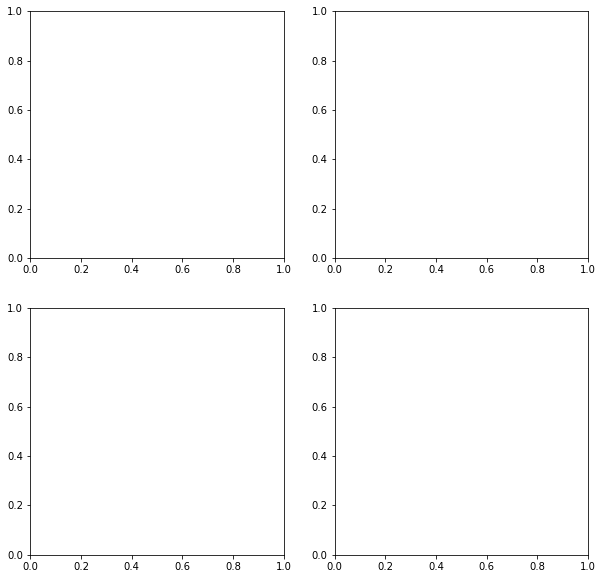

In [27]:
fig,ax = plt.subplots( 2, ndim, figsize=(5*ndim,5*2))

hbins=40
hmax = 10

for fi in range(ndim) :
    ax[0][fi].scatter( all_mean[fi,:], fit_results_mean_val[fi,:])
    xlow, xhigh = ax[0][fi].get_xlim()
    ylow, yhigh = ax[0][fi].get_ylim()
    print("  %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi, xlow, xhigh, ylow, yhigh))
    ax[0][fi].plot( (xlow, xhigh), (true_mu[fi], true_mu[fi]))
    ax[0][fi].plot( (true_mu[fi], true_mu[fi]), (ylow, yhigh))
    

    ax[1][fi].hist( fit_results_mean_val[fi,:], bins=hbins, 
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    ax[1][fi].hist( all_mean[fi,:], bins=hbins, alpha=0.5,
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    ax[1][fi].plot( (true_mu[fi],true_mu[fi]),(0,hmax), linewidth=3)
    

plt.show

In [ ]:
fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        ax[fi1][fi2].scatter( all_cov[fi1,fi2,:], fit_results_cov_val[fi1,fi2,:])
        xlow, xhigh = ax[fi1][fi2].get_xlim()
        ylow, yhigh = ax[fi1][fi2].get_ylim()
        print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi1, fi2, xlow, xhigh, ylow, yhigh))
        ax[fi1][fi2].plot((xlow,xhigh),(true_cov[fi1][fi2], true_cov[fi1][fi2]))
        ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(ylow,yhigh))

plt.show

In [ ]:
fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

hbins=40
hmax=10

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        ax[fi1][fi2].hist( fit_results_cov_val[fi1,fi2,:], bins=hbins, 
                         range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
        ax[fi1][fi2].hist( all_cov[fi1,fi2,:], bins=hbins, alpha=0.5,
                         range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
        xlow, xhigh = ax[fi1][fi2].get_xlim()
        ylow, yhigh = ax[fi1][fi2].get_ylim()
        print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi1, fi2, xlow, xhigh, ylow, yhigh))

        ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(0,hmax), linewidth=3)

plt.show

In [ ]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins = 40
hmax = 10

for fi in range(ndim) :
    ax[fi].hist( fit_results_mean_err[fi,:], bins=hbins )
    ax[fi].plot( (rms_mean[fi], rms_mean[fi]), (0,hmax) )
    
    
plt.show

## Bootstrap error compared with average fit error

In [ ]:
for fi in range(ndim) :
    
    print("  feature %d mean:   rms bootstraps %8.4f,  ave fit err %8.4f    ratio  %8.2f"
         % (fi, rms_mean[fi], ave_fit_err_mean[fi], rms_mean[fi] / ave_fit_err_mean[fi] ))

## Look for outliers in feature coords and weights

In [ ]:
for fi in range( ndim ) :
    
    print( "  feature %2d :  min %12f   max %12f " % ( fi, np.min(train_pts[:,fi]), np.max(train_pts[:,fi])) )

In [ ]:
for si in range( n_samples ) :
    
    max_delta_mean = 0
    for fi in range(ndim) :
        delta = fit_results_mean_val[fi,si] - all_mean[fi,si] 
        if np.abs(delta) > max_delta_mean :
            max_delta_mean = delta
        
    print("  %3d : weight range  %12g  to %12f ,   max delta mean  %12f"
         % (si, all_weight_min[si], all_weight_max[si], max_delta_mean ))

## Look deeper into bootstrap with an outlier

In [ ]:
si = 35

fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, si)
            
with open(fname,'rb') as f :
            
    final_push_weights_scaled = np.load(f)

In [ ]:
fig,ax = plt.subplots( 1, 2, figsize=(2*7,5))

hbins = 60
ax[0].hist( np.log10(final_push_weights_scaled), bins=hbins)
ax[1].hist( final_push_weights_scaled, bins=hbins)
ax[1].set_yscale('log')

plt.show

In [ ]:
selection_mask = final_push_weights_scaled < 100
train_pts_sel = train_pts[ selection_mask ]
weights_sel = final_push_weights_scaled[ selection_mask ]

print(" number of events before selection  %d" % len(train_pts))
print(" number of events passing selection %d" % len(train_pts_sel))
print(" max weight before selection : %f" % np.max(final_push_weights_scaled))
print(" max weight passing selection: %f" % np.max(weights_sel))

In [ ]:
for fi in range( ndim ) :
    
    fit_mean = fit_results_mean_val[fi,si]
    mean_all_evts = all_mean[fi,si]
    mean_sel = ( np.sum( weights_sel * train_pts_sel[:,fi]) ) / ( np.sum( weights_sel ) )
    mean_diff = mean_sel - mean_all_evts
    print(" %2d :  fit mean  %10f   mean all  %10f   selected  %10f   diff %10f  fit diff %10f" % 
          ( fi, fit_mean, mean_all_evts, mean_sel, mean_diff, (mean_sel-fit_mean) ))

## Look at outlier point

In [ ]:
train_pts_antisel = train_pts[ final_push_weights_scaled > 100 ]
train_pts_antisel.shape

In [ ]:
for fi in range( ndim ) :
    
    sigma = np.sqrt(ave_cov[fi,fi])
    
    print(" %2d :  val %10f   mean %10f   sigma %10f  diff/sigma %10f" %
          (fi, train_pts_antisel[0,fi], ave_mean[fi], sigma, (train_pts_antisel[0,fi]-ave_mean[fi])/sigma )
         )

In [ ]:
true_sig

## Calculate the true weights and compare with unfolding weights